# Tutorial: Deploying Regularizers with Giotto-deep

**Author: Henry Kirveslahti**

In this tutorial we discuss the technical details for implementing regularizers and their use in *giotto-deep*. For a less technical introduction to regularization, please refer to the notebook *Basic Tutorial: Regularization with Giotto-deep*.

The notebook is organized as follows:

1. Example of a custom regularizer
2. Hyper-parameter tuning
3. Ad hoc regularizers

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import SGD, Adam, RMSprop
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from gdeep.trainer import Trainer
from gdeep.trainer.regularizer import Regularizer
from gdeep.trainer.regularizer import TihonovRegularizer
from gdeep.search import GiottoSummaryWriter
from gdeep.models import ModelExtractor
from gdeep.utility import DEVICE
from gdeep.search import HyperParameterOptimization
from gdeep.models import FFNet
writer = GiottoSummaryWriter()

No TPUs...


## 1. Custom Regularizers
*Giotto-deep* has already built-in support for $p$-norm regularization, but the framework allows for defining custom regularizers. Below we define the elastic net. It is similar to the existing $p$-norm regularizer, but the penalty term reads

$$
p_i = \lambda_1 \sum \big( ||\beta||_1 \big) + \lambda_2 \sum \big( ||\beta||_2^2 \big)
$$

Typically, a regularizer has just one penalty coefficient $\lambda$. The Elastic net we have two of these, so we need to override the default behavior by specifying the init function.

In [2]:
class ElasticNet:
    def __init__(self, lamda1,lamda2):
        self.lamda1=lamda1
        self.lamda2=lamda2
    def regularization_penalty(self, model):
        """
        The penalty is a combination of the L1 and L2 norms:
        """
        total = torch.tensor(0, dtype=float)
        for parameter in model.parameters():
            total = total + self.lambda1 * torch.norm(parameter, 1) \
                  + self.lambda2 * torch.norm(parameter, 2)**2
        return total    

This is a simple regularizer much in spirit of the $p$-norm regularizers in that it does not require any preprocessing nor parameter updates.

## 2. Hyper parameter tuning
An important aspect of regularization is that of hyper parameter-tuning. To this end, we can use the HPO. Let us first do the example from last notebook: We saw how the value of $\lambda$ about 0.2 boosted the regression coefficient $\alpha_1$ while eliminating the other coefficient $\alpha_2$ that had higher signal-to-noise ratio. Let us see which value of $\lambda$ gives us the best performance when we predict on the validation set.

To recap what we did, first we just run our models from last time on a smaller dataset (it won't take long):

In [3]:
rng = np.random.default_rng()
S=100
z0=rng.standard_normal(S)
z1=0.9*z0+0.1*rng.standard_normal(S)
z2=0.85*z0+0.15*rng.standard_normal(S)
y=z0+rng.standard_normal(S)
X=np.stack([z1,z2],1)
y=y.reshape(-1,1)
y=y.astype(float)
X=X.astype(float)

In [4]:
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.1)
tensor_x_t = torch.Tensor(train_x)
tensor_x_t=tensor_x_t.float()
tensor_y_t = torch.from_numpy(train_y)
tensor_y_t=tensor_y_t.float()
tensor_x_v = torch.Tensor(val_x)
tensor_y_v = torch.from_numpy(val_y)
train_dataset = TensorDataset(tensor_x_t,tensor_y_t)
dl_tr = DataLoader(train_dataset,batch_size=10)
val_dataset = TensorDataset(tensor_x_v,tensor_y_v)
dl_val = DataLoader(val_dataset,batch_size=10)

class Net(nn.Module):
    def __init__(self,featdim='2'):
        super(Net, self).__init__() 
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(eval(featdim), 1, bias=False),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
network=Net('2')

In [6]:
def l2_norm(prediction, y):
    return torch.norm(prediction - y, p=2).to(DEVICE)

In [7]:
loss_fn = nn.MSELoss()
pipe = Trainer(network, (dl_tr, dl_val), loss_fn, writer,l2_norm)
pipe.train(SGD, 20, False, {"lr": 0.1})

/home/mehdi/Documents/giotto-deep/venv/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning:

Can't initialize NVML

/home/mehdi/Documents/giotto-deep/gdeep/trainer/trainer.py:665: UserWarning:

Cannot store data in the PR curve



Epoch 1
-------------------------------
Epoch training loss: 1.138893 	Epoch training l2_norm: 3.20%                                        ward1>)  	[ 9 / 9 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.10000000
Validation results: 
 l2_norm: 2.90%,                 Avg loss: 0.843773 

Epoch 2
-------------------------------
Epoch training loss: 0.929893 	Epoch training l2_norm: 2.97%                                        ward1>)  	[ 9 / 9 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.10000000
Validation results: 
 l2_norm: 2.88%,                 Avg loss: 0.832076 

Epoch 3
-------------------------------
Epoch training loss: 0.925090 	Epoch training l2_norm: 2.96%                                        ward1>)  	[ 9 / 9 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.10000000
Validation results: 
 l2_norm: 2.88%,                 Avg loss: 0.829517 

Epoch 4
-----------------------------

(0.8020720689133871, tensor(2.8321, dtype=torch.float64))

In [8]:
pipe2 = Trainer(network, (dl_tr, dl_val), loss_fn, writer,l2_norm,regularizer=TihonovRegularizer(0.2,p=1))

In [9]:
pipe2.train(SGD, 20, False, {"lr": 0.01})

Epoch 1
-------------------------------
Epoch training loss: 1.706082 	Epoch training l2_norm: 3.79%                                        ward1>)  	[ 9 / 9 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 3.56%,                 Avg loss: 1.265369 

Epoch 2
-------------------------------
Epoch training loss: 1.459512 	Epoch training l2_norm: 3.47%                                        ward1>)  	[ 9 / 9 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 3.28%,                 Avg loss: 1.075488 

Epoch 3
-------------------------------
Epoch training loss: 1.307753 	Epoch training l2_norm: 3.26%                                        ward1>)  	[ 9 / 9 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 3.10%,                 Avg loss: 0.960881 

Epoch 4
-----------------------------

(0.8100613526505803, tensor(2.8462, dtype=torch.float64))

### The optimization - LASSO
Next we take 100 runs on the HPO to try to find the best value for $\lambda$ for the LASSO in the range $[0.05,0.5]$ with step size $0.01$. We specify the regularization parameters by putting the regularizer, together with its parameters in a dictionary. For details on HPO, please see the HPO tutorial.

In [10]:
search = HyperParameterOptimization(pipe, "accuracy", 100, best_not_last=True)
search.regularize=True
search.store_pickle = True
reg=TihonovRegularizer
optimizers_params = {"lr": [0.01]}
dataloaders_params = {}
models_hyperparams = {}
regularization_params={'regularizer':[reg],'lamda':[0.05,0.5,0.01],'p':[1]}

In [11]:
# starting the HPO
search.start(
    [SGD],
    30,
    False,
    optimizers_params,
    dataloaders_params,
    models_hyperparams,
    regularization_params=regularization_params,
    n_accumulated_grads=0,
)

[I 2023-11-30 16:20:44,170] A new study created in memory with name: VQRL9Z1I91HCLGQ5TKFW


Epoch 1
-------------------------------


/home/mehdi/Documents/giotto-deep/gdeep/search/hpo.py:260: UserWarning:

Model cannot be re-initialized. Using existing one.



Epoch training loss: 1.290696 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.857930 

Epoch 2
-------------------------------
Epoch training loss: 1.297288 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.861096 

Epoch 3
-------------------------------
Epoch training loss: 1.297713 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.861556 

Epoch 4
-------------------------------
Epoch training loss: 1.297745 	

[I 2023-11-30 16:20:57,499] Trial 0 finished with value: 0.8094418170852062 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.38, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 0 with value: 0.8094418170852062.


Epoch training loss: 1.297251 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.861457 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.38, 'p': 1}
Best Validation accuracy: tensor(0.8100, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0

[I 2023-11-30 16:21:10,870] Trial 1 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.342211 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.

[I 2023-11-30 16:21:25,138] Trial 2 finished with value: 0.8174008700055477 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.44, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.348777 	Epoch training l2_norm: 0.80%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874590 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.44, 'p': 1}
Best Validation accuracy: tensor(0.8178, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0

[I 2023-11-30 16:21:38,873] Trial 3 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.325158 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.

[I 2023-11-30 16:21:52,415] Trial 4 finished with value: 0.8122853353609738 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.42, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.332384 	Epoch training l2_norm: 0.80%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.865887 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.42, 'p': 1}
Best Validation accuracy: tensor(0.8152, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:21:52,890] Trial 5 pruned. 


Epoch training loss: 0.985272 	Epoch training l2_norm: 0.77%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.75%,                 Avg loss: 0.798350 

Epoch 1
-------------------------------


[I 2023-11-30 16:21:53,340] Trial 6 pruned. 


Epoch training loss: 1.255624 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.80%,                 Avg loss: 0.851189 

Epoch 1
-------------------------------


[I 2023-11-30 16:21:53,779] Trial 7 pruned. 


Epoch training loss: 0.985272 	Epoch training l2_norm: 0.77%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.75%,                 Avg loss: 0.798350 

Epoch 1
-------------------------------


[I 2023-11-30 16:21:54,232] Trial 8 pruned. 


Epoch training loss: 1.076583 	Epoch training l2_norm: 0.77%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.77%,                 Avg loss: 0.810952 

Epoch 1
-------------------------------


[I 2023-11-30 16:21:54,702] Trial 9 pruned. 


Epoch training loss: 1.056653 	Epoch training l2_norm: 0.77%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.77%,                 Avg loss: 0.807793 

Epoch 1
-------------------------------


[I 2023-11-30 16:21:55,176] Trial 10 pruned. 


Epoch training loss: 1.182509 	Epoch training l2_norm: 0.77%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.79%,                 Avg loss: 0.831992 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     tensor(0.2591, grad_fn=<NormBackward1>)  	[ 74 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     tensor(0.9043, grad_fn=<NormBackward1>)  	[ 68 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.0100000

[I 2023-11-30 16:22:08,756] Trial 11 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.383639 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.

[I 2023-11-30 16:22:21,892] Trial 12 finished with value: 0.8214685691510735 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.49, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.390534 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.882321 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.49, 'p': 1}
Best Validation accuracy: tensor(0.8247, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:22:22,350] Trial 13 pruned. 


Epoch training loss: 1.210314 	Epoch training l2_norm: 0.78%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.79%,                 Avg loss: 0.838807 

Epoch 1
-------------------------------


[I 2023-11-30 16:22:22,806] Trial 14 pruned. 


Epoch training loss: 1.350396 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.867008 

Epoch 1
-------------------------------


[I 2023-11-30 16:22:23,247] Trial 15 pruned. 


Epoch training loss: 1.264531 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.80%,                 Avg loss: 0.853819 

Epoch 1
-------------------------------


[I 2023-11-30 16:22:23,692] Trial 16 pruned. 


Epoch training loss: 1.191829 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.79%,                 Avg loss: 0.834212 

Epoch 1
-------------------------------


[I 2023-11-30 16:22:24,166] Trial 17 pruned. 


Epoch training loss: 1.316565 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.861461 

Epoch 1
-------------------------------


[I 2023-11-30 16:22:24,627] Trial 18 pruned. 


Epoch training loss: 1.125506 	Epoch training l2_norm: 0.77%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.78%,                 Avg loss: 0.819747 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     tensor(1.0159, grad_fn=<NormBackward1>)  	[ 67 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183

[I 2023-11-30 16:22:38,182] Trial 19 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:22:38,641] Trial 20 pruned. 


Epoch training loss: 1.246665 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.80%,                 Avg loss: 0.848610 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	

[I 2023-11-30 16:22:51,986] Trial 21 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:22:52,420] Trial 22 pruned. 


Epoch training loss: 1.358816 	Epoch training l2_norm: 0.78%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869642 

Epoch 1
-------------------------------


[I 2023-11-30 16:22:52,853] Trial 23 pruned. 


Epoch training loss: 1.367193 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866404 

Epoch 1
-------------------------------


[I 2023-11-30 16:22:53,285] Trial 24 pruned. 


Epoch training loss: 1.316565 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.861461 

Epoch 1
-------------------------------


[I 2023-11-30 16:22:53,716] Trial 25 pruned. 


Epoch training loss: 1.290696 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.857930 

Epoch 1
-------------------------------


[I 2023-11-30 16:22:54,167] Trial 26 pruned. 


Epoch training loss: 1.358816 	Epoch training l2_norm: 0.78%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869642 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	

[I 2023-11-30 16:23:07,124] Trial 27 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:23:07,561] Trial 28 pruned. 


Epoch training loss: 1.333703 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866782 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:07,993] Trial 29 pruned. 


Epoch training loss: 1.299417 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.860599 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:08,442] Trial 30 pruned. 


Epoch training loss: 1.290696 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.857930 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:08,879] Trial 31 pruned. 


Epoch training loss: 1.375651 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869088 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:09,312] Trial 32 pruned. 


Epoch training loss: 1.350396 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.867008 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	

[I 2023-11-30 16:23:22,270] Trial 33 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:23:22,711] Trial 34 pruned. 


Epoch training loss: 1.342211 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.864071 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:23,195] Trial 35 pruned. 


Epoch training loss: 1.367193 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866404 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:23,656] Trial 36 pruned. 


Epoch training loss: 1.325158 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.864099 

Epoch 1
-------------------------------
Epoch training loss: 1.375651 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000


[I 2023-11-30 16:23:24,160] Trial 37 pruned. 


Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869088 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	Epoch training l2_norm: 0.81%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 

[I 2023-11-30 16:23:38,321] Trial 38 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:23:38,809] Trial 39 pruned. 


Epoch training loss: 1.154240 	Epoch training l2_norm: 0.77%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.78%,                 Avg loss: 0.825639 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:39,310] Trial 40 pruned. 


Epoch training loss: 1.228593 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.80%,                 Avg loss: 0.843606 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	

[I 2023-11-30 16:23:52,689] Trial 41 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:23:53,165] Trial 42 pruned. 


Epoch training loss: 1.342211 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.864071 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:53,705] Trial 43 pruned. 


Epoch training loss: 1.375651 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869088 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:54,153] Trial 44 pruned. 


Epoch training loss: 1.005925 	Epoch training l2_norm: 0.77%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.76%,                 Avg loss: 0.800792 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:54,601] Trial 45 pruned. 


Epoch training loss: 1.358816 	Epoch training l2_norm: 0.78%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869642 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:55,041] Trial 46 pruned. 


Epoch training loss: 1.307922 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.858868 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:55,480] Trial 47 pruned. 


Epoch training loss: 1.333703 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866782 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:55,919] Trial 48 pruned. 


Epoch training loss: 1.273387 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.856501 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:56,367] Trial 49 pruned. 


Epoch training loss: 1.375651 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869088 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:56,807] Trial 50 pruned. 


Epoch training loss: 1.106091 	Epoch training l2_norm: 0.77%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.77%,                 Avg loss: 0.816075 

Epoch 1
-------------------------------


[I 2023-11-30 16:23:57,275] Trial 51 pruned. 


Epoch training loss: 1.383639 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.872057 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	

[I 2023-11-30 16:24:11,226] Trial 52 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.358816 	Epoch training l2_norm: 0.78%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.

[I 2023-11-30 16:24:11,662] Trial 53 pruned. 


Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	Epoch training l2_norm: 0.81%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.886076 

Epoch 4
-----------------------

[I 2023-11-30 16:24:24,655] Trial 54 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:24:25,090] Trial 55 pruned. 


Epoch training loss: 1.350396 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.867008 

Epoch 1
-------------------------------


[I 2023-11-30 16:24:25,528] Trial 56 pruned. 


Epoch training loss: 1.375651 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869088 

Epoch 1
-------------------------------


[I 2023-11-30 16:24:25,962] Trial 57 pruned. 


Epoch training loss: 1.325158 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.864099 

Epoch 1
-------------------------------


[I 2023-11-30 16:24:26,416] Trial 58 pruned. 


Epoch training loss: 1.367193 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866404 

Epoch 1
-------------------------------


[I 2023-11-30 16:24:26,852] Trial 59 pruned. 


Epoch training loss: 1.342211 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.864071 

Epoch 1
-------------------------------


[I 2023-11-30 16:24:27,290] Trial 60 pruned. 


Epoch training loss: 1.383639 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.872057 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     tensor(0.7000, grad_fn=<NormBackward1>)  	[ 76 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183

[I 2023-11-30 16:24:40,497] Trial 61 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:24:40,937] Trial 62 pruned. 


Epoch training loss: 1.367193 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866404 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	

[I 2023-11-30 16:24:54,329] Trial 63 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.358816 	Epoch training l2_norm: 0.78%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.

[I 2023-11-30 16:24:54,785] Trial 64 pruned. 


Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869642 

Epoch 1
-------------------------------


[I 2023-11-30 16:24:55,253] Trial 65 pruned. 


Epoch training loss: 1.375651 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869088 

Epoch 1
-------------------------------


[I 2023-11-30 16:24:55,714] Trial 66 pruned. 


Epoch training loss: 1.383639 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.872057 

Epoch 1
-------------------------------


[I 2023-11-30 16:24:56,180] Trial 67 pruned. 


Epoch training loss: 1.350396 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.867008 

Epoch 1
-------------------------------


[I 2023-11-30 16:24:56,648] Trial 68 pruned. 


Epoch training loss: 1.333703 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866782 

Epoch 1
-------------------------------
Epoch training loss: 1.046611 	Epoch training l2_norm: 0.77%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000


[I 2023-11-30 16:24:57,122] Trial 69 pruned. 


Validation results: 
 l2_norm: 0.76%,                 Avg loss: 0.806290 

Epoch 1
-------------------------------


[I 2023-11-30 16:24:57,583] Trial 70 pruned. 


Epoch training loss: 1.173138 	Epoch training l2_norm: 0.77%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.79%,                 Avg loss: 0.829823 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	

[I 2023-11-30 16:25:11,533] Trial 71 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.383639 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     tensor(0.3924, grad_fn=<NormBackward1>)  	[ 35 / 90 ]    

[I 2023-11-30 16:25:11,974] Trial 72 pruned. 


Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.872057 

Epoch 1
-------------------------------


[I 2023-11-30 16:25:12,421] Trial 73 pruned. 


Epoch training loss: 1.367193 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866404 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	

[I 2023-11-30 16:25:26,852] Trial 74 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:25:27,324] Trial 75 pruned. 


Epoch training loss: 1.375651 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869088 

Epoch 1
-------------------------------


[I 2023-11-30 16:25:27,803] Trial 76 pruned. 


Epoch training loss: 1.358816 	Epoch training l2_norm: 0.78%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869642 

Epoch 1
-------------------------------


[I 2023-11-30 16:25:28,281] Trial 77 pruned. 


Epoch training loss: 1.383639 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.872057 

Epoch 1
-------------------------------


[I 2023-11-30 16:25:28,759] Trial 78 pruned. 


Epoch training loss: 1.367193 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866404 

Epoch 1
-------------------------------


[I 2023-11-30 16:25:29,225] Trial 79 pruned. 


Epoch training loss: 1.342211 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.864071 

Epoch 1
-------------------------------


[I 2023-11-30 16:25:29,725] Trial 80 pruned. 


Epoch training loss: 1.210314 	Epoch training l2_norm: 0.78%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.79%,                 Avg loss: 0.838807 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	

[I 2023-11-30 16:25:43,748] Trial 81 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:25:44,234] Trial 82 pruned. 


Epoch training loss: 1.375651 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869088 

Epoch 1
-------------------------------


[I 2023-11-30 16:25:44,714] Trial 83 pruned. 


Epoch training loss: 1.383639 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.872057 

Epoch 1
-------------------------------


[I 2023-11-30 16:25:45,199] Trial 84 pruned. 


Epoch training loss: 1.350396 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.867008 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     tensor(1.9481, grad_fn=<NormBackward1>)  	[ 46 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183

[I 2023-11-30 16:25:59,250] Trial 85 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:25:59,719] Trial 86 pruned. 


Epoch training loss: 1.367193 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866404 

Epoch 1
-------------------------------


[I 2023-11-30 16:26:00,244] Trial 87 pruned. 


Epoch training loss: 1.358816 	Epoch training l2_norm: 0.78%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869642 

Epoch 1
-------------------------------


[I 2023-11-30 16:26:00,726] Trial 88 pruned. 


Epoch training loss: 1.383639 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.872057 

Epoch 1
-------------------------------


[I 2023-11-30 16:26:01,225] Trial 89 pruned. 


Epoch training loss: 1.375651 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869088 

Epoch 1
-------------------------------
Epoch training loss: 1.316565 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                       	Batch training l2_norm:  tensor(0.9840, grad_fn=<NormBackward1>)  	[ 66 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000


[I 2023-11-30 16:26:01,737] Trial 90 pruned. 


Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.861461 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     tensor(0.4850, grad_fn=<NormBackward1>)  	[ 45 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183 

Epoch 3
-------------------------------
Epoch training loss: 1.396749 	Epoch training l2_norm: 0.81%                                        ard1>)  	[ 90 / 90 ]                      
Time taken for this ep

[I 2023-11-30 16:26:15,515] Trial 91 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     tensor(0.5932, grad_fn=<NormBackward1>)  	[ 61 / 90 ]    

[I 2023-11-30 16:26:29,708] Trial 92 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------


[I 2023-11-30 16:26:30,168] Trial 93 pruned. 


Epoch training loss: 1.383639 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.872057 

Epoch 1
-------------------------------


[I 2023-11-30 16:26:30,641] Trial 94 pruned. 


Epoch training loss: 1.367193 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866404 

Epoch 1
-------------------------------
Batch training loss:  1.3781865820998238  	Batch training l2_norm:  tensor(1.4179, grad_fn=<NormBackward1>)  	[ 83 / 90 ]                     

[I 2023-11-30 16:26:31,098] Trial 95 pruned. 


Epoch training loss: 1.350396 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.867008 

Epoch 1
-------------------------------


[I 2023-11-30 16:26:31,555] Trial 96 pruned. 


Epoch training loss: 1.375651 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.869088 

Epoch 1
-------------------------------
Epoch training loss: 1.391823 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     tensor(0.0387, grad_fn=<NormBackward1>)  	[ 22 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.874871 

Epoch 2
-------------------------------
Epoch training loss: 1.396010 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.878183

[I 2023-11-30 16:26:45,572] Trial 97 finished with value: 0.8229174558994767 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}. Best is trial 1 with value: 0.8229174558994767.


Epoch training loss: 1.398603 	Epoch training l2_norm: 0.81%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.885154 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'lamda': 0.5, 'p': 1}
Best Validation accuracy: tensor(0.8262, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.383639 	Epoch training l2_norm: 0.79%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.

[I 2023-11-30 16:26:46,032] Trial 98 pruned. 


Validation results: 
 l2_norm: 0.82%,                 Avg loss: 0.872057 

Epoch 1
-------------------------------


[I 2023-11-30 16:26:46,515] Trial 99 pruned. 


Epoch training loss: 1.367193 	Epoch training l2_norm: 0.78%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.81%,                 Avg loss: 0.866404 

Study statistics: 
Number of pruned trials:  76
Number of complete trials:  24
******************** BEST TRIAL: ********************
Metric Value for best trial:  0.8229174558994767
Parameters Values for best trial:  {'optimizer': 'SGD', 'lr': 0.01, 'lamda': 0.5, 'p': 1, 'regularizer': 'TihonovRegularizer'}
DateTime start of the best trial:  2023-11-30 16:20:57.500038


### Optimization - Custom regularizer
Next we do the same thing for our custom regularizer that we defined above.

In [12]:
search = HyperParameterOptimization(pipe, "accuracy", 20, best_not_last=True)
search.regularize=True
search.store_pickle = True
reg=ElasticNet
optimizers_params = {"lr": [0.01]}
dataloaders_params = {}
models_hyperparams = {}
regularization_params={'reg':[reg], 'lambda1':[0.15,0.85,0.01],'lambda2':[0.0001,0.1,0.01]}

In [13]:
search.start(
    [SGD],
    30,
    False,
    optimizers_params,
    dataloaders_params,
    models_hyperparams,
    regularization_params=regularization_params,
    n_accumulated_grads=0,
)

[I 2023-11-30 16:26:47,447] A new study created in memory with name: NVLYHM6KRTOCXV6N432M
/home/mehdi/Documents/giotto-deep/venv/lib/python3.8/site-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [0.0001, 0.1] and step=0.01, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0901].

/home/mehdi/Documents/giotto-deep/gdeep/search/hpo.py:260: UserWarning:

Model cannot be re-initialized. Using existing one.



Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.78%,                 Avg loss: 0.839323 

Epoch 2
-------------------------------


/home/mehdi/Documents/giotto-deep/gdeep/trainer/trainer.py:665: UserWarning:

Cannot store data in the PR curve



Epoch training loss: 0.925486 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.76%,                 Avg loss: 0.823773 

Epoch 3
-------------------------------
Epoch training loss: 0.918219 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.76%,                 Avg loss: 0.821130 

Epoch 4
-------------------------------
Epoch training loss: 0.917620 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.76%,                 Avg loss: 0.819256 

Epoch 5
-------------------------------
Epoch training loss: 0.917497 	

[I 2023-11-30 16:27:00,359] Trial 0 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.19, 'lambda2': 0.0201, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.19, 'lambda2': 0.0201}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time

[I 2023-11-30 16:27:13,080] Trial 1 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.79, 'lambda2': 0.07010000000000001, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.79, 'lambda2': 0.07010000000000001}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]             

[I 2023-11-30 16:27:25,771] Trial 2 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.8, 'lambda2': 0.0201, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.8, 'lambda2': 0.0201}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time 

[I 2023-11-30 16:27:38,469] Trial 3 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.67, 'lambda2': 0.0301, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.67, 'lambda2': 0.0301}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time

[I 2023-11-30 16:27:51,160] Trial 4 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.38, 'lambda2': 0.0601, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.38, 'lambda2': 0.0601}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time

[I 2023-11-30 16:28:03,843] Trial 5 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.22999999999999998, 'lambda2': 0.07010000000000001, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.22999999999999998, 'lambda2': 0.07010000000000001}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90

[I 2023-11-30 16:28:16,486] Trial 6 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.54, 'lambda2': 0.050100000000000006, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.54, 'lambda2': 0.050100000000000006}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]            

[I 2023-11-30 16:28:29,330] Trial 7 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.27, 'lambda2': 0.050100000000000006, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.27, 'lambda2': 0.050100000000000006}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]            

[I 2023-11-30 16:28:42,053] Trial 8 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.56, 'lambda2': 0.0801, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.56, 'lambda2': 0.0801}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time

[I 2023-11-30 16:28:54,875] Trial 9 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.19, 'lambda2': 0.0001, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.19, 'lambda2': 0.0001}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time

[I 2023-11-30 16:29:07,945] Trial 10 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.39, 'lambda2': 0.0001, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.39, 'lambda2': 0.0001}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time

[I 2023-11-30 16:29:21,628] Trial 11 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.77, 'lambda2': 0.0901, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.77, 'lambda2': 0.0901}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     tenso

[I 2023-11-30 16:29:34,965] Trial 12 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.6900000000000001, 'lambda2': 0.0301, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     ensor(0.2697, grad_fn=<NormBackward1>)  	[ 4 / 90 ]                     tensor(0.8329, grad_fn=<NormBackward1>)  	[ 78 / 90 ]                     tensor(1.6350, grad_fn=<NormBackward1>)  	[ 86 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.78%,                 Avg loss: 0.839323 

Epoch 2
-------------------------------
Epoch training loss: 0.925486 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     tensor(0.2229, grad_fn=<NormBackward1>)  	[ 73 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.76%,                 Avg loss: 0.823773 

Epoch 3
-------------------------------
Epoch training loss:

[I 2023-11-30 16:29:47,879] Trial 13 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.38, 'lambda2': 0.0201, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.38, 'lambda2': 0.0201}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     ensor

[I 2023-11-30 16:30:00,806] Trial 14 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.65, 'lambda2': 0.07010000000000001, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.65, 'lambda2': 0.07010000000000001}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     ensor(0.2697, grad_fn=<NormBackward1>)  	[ 4 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.78%,                 Avg loss

[I 2023-11-30 16:30:13,845] Trial 15 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.85, 'lambda2': 0.040100000000000004, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     tensor(0.1390, grad_fn=<NormBackward1>)  	[ 43 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.78%,                 Avg loss: 0.839323 

Epoch 2
-------------------------------
Epoch training loss: 0.925486 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.76%,                 Avg loss: 0.823773 

Epoch 3
-------------------------------
Epoch training loss: 0.918219 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0

[I 2023-11-30 16:30:26,958] Trial 16 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.47, 'lambda2': 0.0101, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.47, 'lambda2': 0.0101}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time

[I 2023-11-30 16:30:40,608] Trial 17 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.15, 'lambda2': 0.0901, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.15, 'lambda2': 0.0901}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time

[I 2023-11-30 16:30:54,168] Trial 18 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.3, 'lambda2': 0.0601, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch 1
-------------------------------
Epoch training loss: 1.133319 	Epoch training l2_norm: 0.85%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.78%,                 Avg loss: 0.839323 

Epoch 2
-------------------------------
Epoch training loss: 0.925486 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.76%,                 Avg loss: 0.823773 

Epoch 3
-------------------------------
Epoch training loss: 0.918219 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.76%,                 Avg loss: 0.821130 

Epoch 4
-----------------------

[I 2023-11-30 16:31:07,455] Trial 19 finished with value: 0.7433606476054183 and parameters: {'optimizer': 'SGD', 'lr': 0.01, 'lambda1': 0.48, 'lambda2': 0.040100000000000004, 'reg': 'ElasticNet'}. Best is trial 0 with value: 0.7433606476054183.


Epoch training loss: 0.916563 	Epoch training l2_norm: 0.76%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.01000000
Validation results: 
 l2_norm: 0.74%,                 Avg loss: 0.788486 

******************** RESULTS ********************
 
Model:  Net 
Model Hyperparameters: {}
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Optimizer parameters: {'lr': 0.01}
Dataloader parameters: {}
LR-scheduler parameters: None
Regularizer parameters: {'reg': <class '__main__.ElasticNet'>, 'lambda1': 0.48, 'lambda2': 0.040100000000000004}
Best Validation accuracy: tensor(2.9048, dtype=torch.float64)
Study statistics: 
Number of pruned trials:  0
Number of complete trials:  20
******************** BEST TRIAL: ********************
Metric Value for best trial:  0.743360647

## 3. Ad hoc regularizers

The penalties in the regularizers that we have seen so far have been straightforward functions of the model parameters. Here we show an example of an ad hoc regularizer that directly penalizes the behavior of the model. Such regularizers may depend on external parameters, and the logic is completely wrapped in the regularizer object.

First we generate some data:

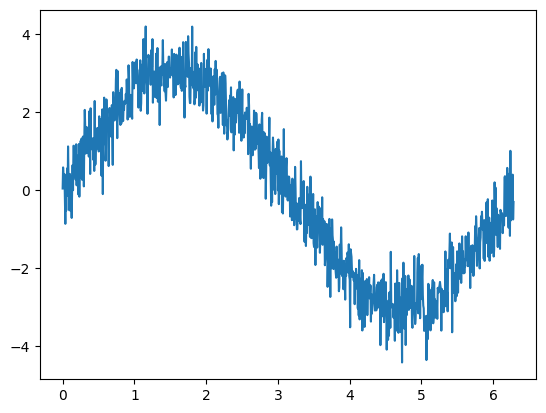

In [14]:
S=1000
X=np.linspace(0,2*np.pi,S)
y=3*np.sin(X)+0.5*rng.standard_normal(S)
plt.plot(X,y)

In [15]:
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.1)
tensor_x_t = torch.Tensor(train_x).reshape(-1, 1)
tensor_x_t=tensor_x_t.float()
tensor_y_t = torch.from_numpy(train_y).reshape(-1, 1)
tensor_y_t=tensor_y_t.float()
tensor_x_v = torch.Tensor(val_x).reshape(-1, 1)
tensor_y_v = torch.from_numpy(val_y).reshape(-1, 1)
train_dataset = TensorDataset(tensor_x_t,tensor_y_t)
dl_tr = DataLoader(train_dataset,batch_size=10)
val_dataset = TensorDataset(tensor_x_v,tensor_y_v)
dl_val = DataLoader(val_dataset,batch_size=10)

class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        self.seqmodel = FFNet(arch=[1, 10,10,10, 1])

    def forward(self, x):
        return self.seqmodel(x)


model = model1()

We fit a basic unregularized model:

In [16]:
loss_fn = nn.MSELoss()
pipe = Trainer(model, (dl_tr, dl_val), loss_fn, writer,l2_norm)
pipe.train(SGD, 200, False, {"lr": 0.1})

Epoch 1
-------------------------------
Epoch training loss: 3.141686 	Epoch training l2_norm: 5.23%                                        ward1>)  	[ 90 / 90 ]                      ensor(2.7563, grad_fn=<NormBackward1>)  	[ 38 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.10000000
Validation results: 
 l2_norm: 5.98%,                 Avg loss: 3.700457 

Epoch 2
-------------------------------


/home/mehdi/Documents/giotto-deep/gdeep/trainer/trainer.py:665: UserWarning:

Cannot store data in the PR curve



Epoch training loss: 1.743931 	Epoch training l2_norm: 3.98%                                        rd1>)  	[ 90 / 90 ]                       
Time taken for this epoch: 0.00s
Learning rate value: 0.10000000
Validation results: 
 l2_norm: 4.52%,                 Avg loss: 2.169215 

Epoch 3
-------------------------------
Epoch training loss: 1.199008 	Epoch training l2_norm: 3.33%                                        ward1>)  	[ 90 / 90 ]                     tensor(1.8068, grad_fn=<NormBackward1>)  	[ 51 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.10000000
Validation results: 
 l2_norm: 3.23%,                 Avg loss: 1.088290 

Epoch 4
-------------------------------
Epoch training loss: 1.013476 	Epoch training l2_norm: 3.07%                                        ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 0.00s
Learning rate value: 0.10000000
Validation results: 
 l2_norm: 3.29%,                 Avg loss: 1.106831

(0.5400117442995163, tensor(2.2638, dtype=torch.float64))

In [17]:
resp=pipe.model(dl_tr.dataset.tensors[0])
X_t=dl_tr.dataset.tensors[0].detach().numpy().reshape(-1)
y_t=resp.detach().numpy().reshape(-1)

Let us take a look of the graph of the model we defined:

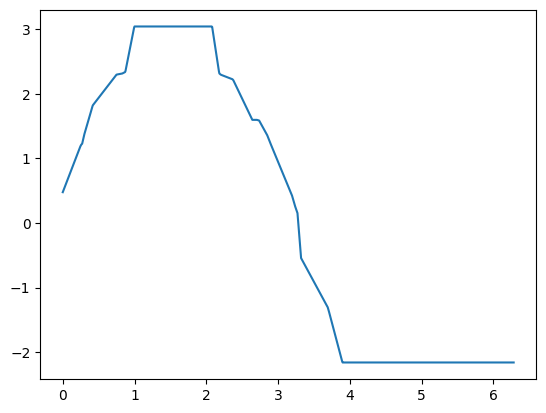

In [18]:
ind=np.argsort(X_t)
plt.plot(X_t[ind],y_t[ind])

Next we define an ad hoc regularizer that penalizes the function from attaining values higher than 2, and we do this in a very barbarian way to demonstrate the regularization logic. In general, these kind of restrictions could also be effectively imposed by a suitable model architecture.

Our regularizer evaluates the model on a grid, which is defined by preprocess step. The penalty consists of evaluating the model on this grid, and then picking out the points where the model exceeded 2. The penalty is the squared sum of the model values at these points.

In [19]:
class CapReg:
    def __init__(self,lamda):
        self.lamda=lamda
        self.X=torch.linspace(0,2*torch.pi,1000)

    def regularization_penalty(self, model):
        """
        We penalized the squared values of the function at the points where it attains value higher than 2.
        """
        res=model(self.X.reshape(-1,1)).reshape(-1)
        inds1=torch.where(res>2)        
        X1=self.X[inds1]
        res1=model(X1.reshape(-1,1)).reshape(-1)
        return torch.sum(res1**2)

In [20]:
reg=CapReg(lamda=1/(2*S))

In [21]:
pipe2 = Trainer(model, (dl_tr, dl_val), loss_fn, writer,l2_norm,regularizer=reg)


The regression penalty that we defined is computed for every batch in our dataset. This way, their gradients are updated every single batch. A reasonable pick for the regression penalty coefficient $\lambda$ should then be inversely proportional to the number of batches.

In [22]:
pipe2.train(SGD, 10, False, {"lr": 0.1})

Epoch 1
-------------------------------
Epoch training loss: 126.537467 	Epoch training l2_norm: 5.33%                                      ward1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 l2_norm: 4.03%,                 Avg loss: 1.664963 

Epoch 2
-------------------------------
Epoch training loss: 294.389519 	Epoch training l2_norm: 4.32%                                      ward1>)  	[ 90 / 90 ]                     
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 l2_norm: 3.72%,                 Avg loss: 1.435014 

Epoch 3
-------------------------------
Epoch training loss: 537.780211 	Epoch training l2_norm: 4.13%                                      ard1>)  	[ 90 / 90 ]                      
Time taken for this epoch: 1.00s
Learning rate value: 0.10000000
Validation results: 
 l2_norm: 4.30%,                 Avg loss: 1.929356 

Epoch 4
----------------------

(0.9358044771156159, tensor(2.9968, dtype=torch.float64))

Let us now take a look at the graphs of the two models:

In [23]:
resp=pipe2.model(dl_tr.dataset.tensors[0])
X_t2=dl_tr.dataset.tensors[0].detach().numpy().reshape(-1)
y_t2=resp.detach().numpy().reshape(-1)
ind2=np.argsort(X_t2)

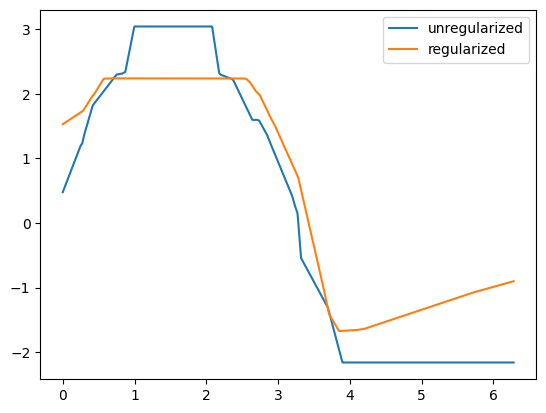

In [24]:
plt.plot(X_t[ind],y_t[ind], label = 'unregularized')
plt.plot(X_t2[ind2],y_t2[ind2], label = 'regularized')
plt.legend()
plt.show()

We see the regularizer does penalize the graph from taking values greater than 2. This type of regularization will also have side effects on the rest of graph, because the model is quite simple and there is no straightforward connection between the function value being higher than 2 and the network weights. This could be improved by tailoring the model architecture possibly in conjuction with a suitable regularizer.